## Image convolution for edge detection

Convolution is a central operation in image processing, where the image is filtered with a kernel (also called filter or convolution matrix).
Depending on the kernel that is used, we can e.g. blur or sharpen the images or detect edges.

In the following we use the sobel-v filter to detect vertical edges in an image. The operation is defined as

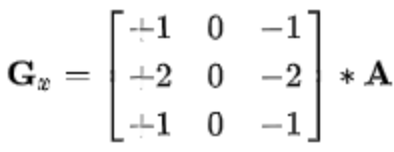!,

where the Sobel filter S<sub>x</sub> in x-direction is convolved with the image A resulting in the approximate gradient G<sub>x</sub> in x-direction. Moreover, one can calculate the gradient in vertical direction as well

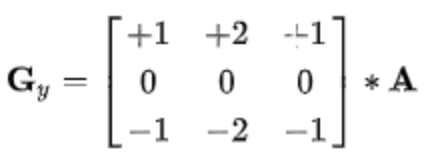!

and obtain the magnitude of the gradient at each pixel as:

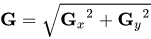!

Generally, the discrete convolution is computed as

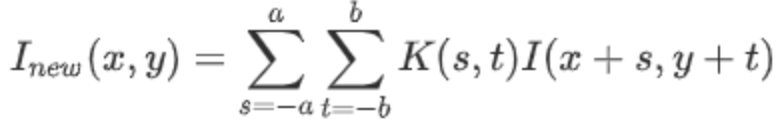,

where K(s,t) is the kernel, I(x,y) is the original and image I<sub>new</sub>(x,y) is the resulting filtered image. In our case, for the Sobel-filter K has shape 3x3.  Each pixel in I<sub>new</sub>(x,y) is the result of the sum over all neighborhood-pixels multiplied (weighted) with its corresponding filter value.

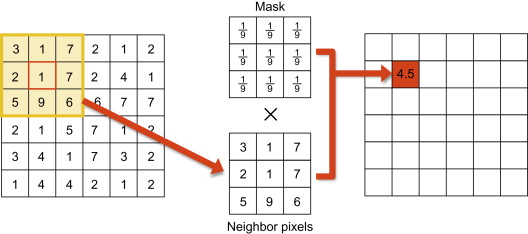

Since the final pixel value in depends only on its neighborhood and the (fixed) values in the kernel, this operation can be run in parallel for each pixel.

Sources: [1](https://www.sciencedirect.com/topics/computer-science/linear-convolution)

In [1]:
# define image path
import functools
import time

image_path = "../codes/image_processing/sobel_v_convolution/photographer.png"

In [51]:
# Define some support functions for loading/tiling the image and showing it and its filtered version.

In [105]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters, io


def read_image(image_path, tiles_per_dimension=1):
    # read image and normalize
    image = io.imread(image_path).astype(np.float32)
    image -= np.min(image)
    image /= np.max(image)
    image = np.tile(image, (tiles_per_dimension, tiles_per_dimension))
    return image


def keep_valid_image(filtered_image, filter):
    # ignore edges, which are not a valid result
    filter_height, filter_width = filter.shape
    filter_height_halved = filter_height // 2
    filter_width_halved = filter_width // 2
    return filtered_image[filter_height_halved:-filter_height_halved,
                         filter_width_halved:-filter_width_halved]


def show_image(image_orig, image_filtered):
    # show images
    fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8, 4))
    axes[0].imshow(image_orig, cmap=plt.cm.gray)
    axes[0].set_title('Original')
    axes[1].imshow(image_filtered, cmap=plt.cm.gray)
    axes[1].set_title('Processed')
    for ax in axes:
        ax.axis('off')
    plt.tight_layout()
    plt.show()


def get_blocks_per_grid(threads_per_block, image_shape):
    image_shape = np.max(image_shape)  # since our image has roughly square shape: (539, 540), we do choose same size for both dimensions
    blocks_per_grid_x = int(np.ceil(image_shape / threads_per_block[0]))
    blocks_per_grid_y = int(np.ceil(image_shape / threads_per_block[1]))
    return (blocks_per_grid_x, blocks_per_grid_y)


def print_min_and_max_pixel_vals(image):
    print("min. pixel value: " + str(np.min(edges_sobel_v)))
    print("max. pixel value: " + str(np.max(edges_sobel_v)))


from contextlib import contextmanager
@contextmanager
def timeit_context(name, repeats=1):
    startTime = time.time()
    for ind in range(repeats):
        yield
    elapsedTime = time.time() - startTime
    print(f"{name} is {elapsedTime * 1000./repeats:#.3} ms")

In [43]:
### Scikit-Image version

Scikit-Image CPU execution time is 2.63 ms
min. pixel value: -0.87254906
max. pixel value: 0.9196078


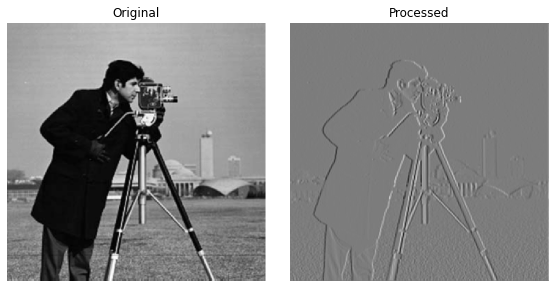

In [106]:
image = read_image(image_path)

# filter vertical edges with sobel_v
with timeit_context('Scikit-Image CPU execution time'):
    edges_sobel_v = filters.sobel_v(image)

# print min- and max-values for comparison with reference implementation
print_min_and_max_pixel_vals(edges_sobel_v)

show_image(image, edges_sobel_v)

In [42]:
### CUDA implementation

In [ ]:
# Let's write our own CPU version of the convolution function using Numba.

In [4]:
# from numba import jit, autojit, prange
from numba import jit

# kernel definition
# @jit(nopython=True, parallel=True)
@jit(nopython=True)
def filter2d_cpu(image, filt, result):
    image_height, image_width = image.shape
    filter_height, filter_width = filt.shape
    filter_height_halved = filter_height // 2
    filter_width_halved = filter_width // 2

    for row in range(0, image_height):
        for col in range(0, image_width):
            if (row > filter_height_halved and row < image_height - filter_height_halved):
                if (col > filter_width_halved and col < image_width - filter_width_halved):
                    sum = 0.0
                    for conv_index_y in range(-filter_height_halved, filter_height_halved + 1):
                        for conv_index_x in range(-filter_width_halved, filter_width_halved + 1):
                            kernelCoord = filter_height_halved + conv_index_y, filter_width_halved + conv_index_x
                            imageCoord = row + conv_index_y, col + conv_index_x
                            sum += filt[kernelCoord] * image[imageCoord]
                    result[row, col] = sum

CPU execution time is 4.35 ms
min. pixel value: -0.87254906
max. pixel value: 0.9196078


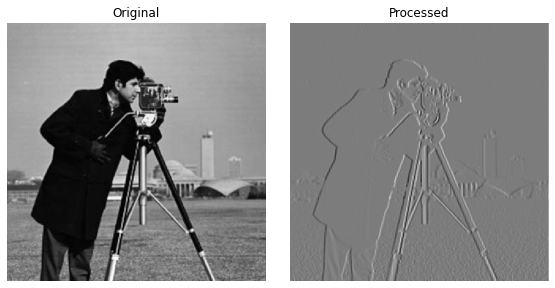

In [107]:
import numpy as np

# read image and define output image
image = read_image(image_path, 1)
edges_sobel_v = np.zeros_like(image)

# Define sobel filter for vertical edges
sobel_v_filter = (1. / 4) * np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=np.float32)

# filter image
with timeit_context('CPU execution time'):
    filter2d_cpu(image, sobel_v_filter, edges_sobel_v)

# strip invalid image regions and show
edges_sobel_v = keep_valid_image(edges_sobel_v, sobel_v_filter)

print_min_and_max_pixel_vals(edges_sobel_v)

show_image(image, edges_sobel_v)

In [41]:
# Same result as Scikit-Image. Great. Now let's rewrite the convolution function to get a naive CUDA kernel.

In [6]:
from numba import cuda

# kernel definition
@cuda.jit
def filter2d_gpu(image, filt, result):
    image_height, image_width = image.shape
    filter_height, filter_width = filt.shape
    filter_height_halved = filter_height // 2
    filter_width_halved = filter_width // 2

    row = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y
    col = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x

    if (row > filter_height_halved and row < image_height - filter_height_halved):
        if (col > filter_width_halved and col < image_width - filter_width_halved):
            sum = 0.0
            for conv_index_y in range(-filter_height_halved, filter_height_halved + 1):
                for conv_index_x in range(-filter_width_halved, filter_width_halved + 1):
                    kernelCoord = filter_height_halved + conv_index_y, filter_width_halved + conv_index_x
                    imageCoord = row + conv_index_y, col + conv_index_x
                    sum += filt[kernelCoord] * image[imageCoord]
            result[row, col] = sum

CPU execution time is 7.25 ms
GPU execution time is 14.3 ms
min. pixel value: -0.87254906
max. pixel value: 0.9196078


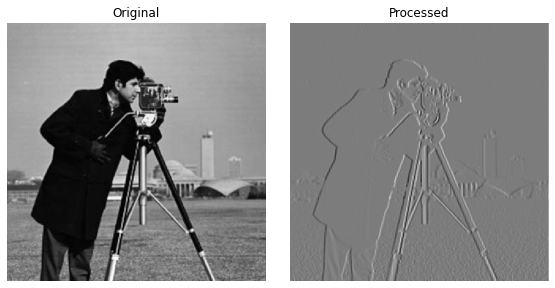

In [108]:
import numpy as np
import matplotlib.pyplot as plt
from numba import cuda
from skimage import io

# read image and define output image
image = read_image(image_path, 1)
edges_sobel_v = np.zeros_like(image)

# Define sobel filter for vertical edges
sobel_v_filter = (1. / 4) * np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=np.float32)

filter_height, filter_width = sobel_v_filter.shape
filter_height_halved = filter_height // 2
filter_width_halved = filter_width // 2

threads_per_block = (16, 16)
blocks_per_grid = get_blocks_per_grid(threads_per_block, image.shape)

# resCPU = %timeit -n 2 -r 10 -o filter2d_cpu(image, sobel_v_filter, edges_sobel_v)
with timeit_context('CPU execution time'):
    filter2d_cpu(image, sobel_v_filter, edges_sobel_v)

# resGPU = %timeit -n 2 -r 10 -o filter2d_gpu[blocks_per_grid, threads_per_block](image, sobel_v_filter, edges_sobel_v)
with timeit_context('GPU execution time'):
    filter2d_gpu[blocks_per_grid, threads_per_block](image, sobel_v_filter, edges_sobel_v)

# strip invalid image regions and show
edges_sobel_v = keep_valid_image(edges_sobel_v, sobel_v_filter)

print_min_and_max_pixel_vals(edges_sobel_v)

show_image(image, edges_sobel_v)

In [70]:
# GPU is not much faster than CPU. But what happens for larger images? Let's try with 10x10 tiling of the image ...

CPU execution time is 4.36e+02 ms
GPU execution time is 67.1 ms
min. pixel value: -0.87254906
max. pixel value: 0.9196078


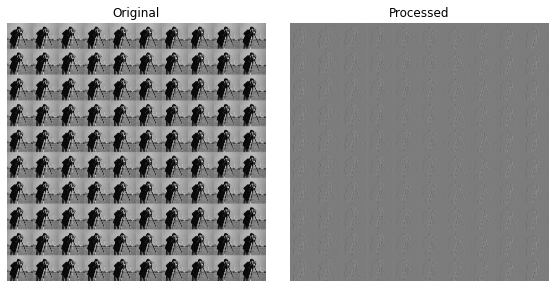

In [109]:
import numpy as np
import matplotlib.pyplot as plt
from numba import cuda
from skimage import io

# read image and define output image
image = read_image(image_path, 10)
edges_sobel_v = np.zeros_like(image)

# Define sobel filter for vertical edges
sobel_v_filter = (1. / 4) * np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=np.float32)

threads_per_block = (16, 16)
blocks_per_grid = get_blocks_per_grid(threads_per_block, image.shape)

# filter vertical edges with sobel_v_filter

# resCPU = %timeit -n 2 -r 10 -o filter2d_cpu(image, sobel_v_filter, edges_sobel_v)
with timeit_context('CPU execution time'):
    filter2d_cpu(image, sobel_v_filter, edges_sobel_v)

# resGPU = %timeit -n 2 -r 10 -o filter2d_gpu[blocks_per_grid, threads_per_block](image, sobel_v_filter, edges_sobel_v)
with timeit_context('GPU execution time'):
    filter2d_gpu[blocks_per_grid, threads_per_block](image, sobel_v_filter, edges_sobel_v)
    cuda.synchronize()

print_min_and_max_pixel_vals(edges_sobel_v)
    
show_image(image, edges_sobel_v)

In [39]:
# There we go: GPU is significantly faster. The missing speed-up in the first example is due to memory transfer to the GPU.
# Let's measure separately the time spent on data transfer and GPU computation.

In [112]:
import numpy as np
import matplotlib.pyplot as plt
from numba import cuda
from skimage import io

# read image and define output image
image = read_image(image_path, 1)
edges_sobel_v = np.zeros_like(image)

# Define sobel filter for vertical edges
sobel_v_filter = (1. / 4) * np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=np.float32)

# filter_height, filter_width = sobel_v_filter.shape
# filter_height_halved = filter_height // 2
# filter_width_halved = filter_width // 2

threads_per_block = (16, 16)
blocks_per_grid = get_blocks_per_grid(threads_per_block, image.shape)

with timeit_context('GPU time including with transfer'):
    filter2d_gpu[blocks_per_grid, threads_per_block](image, sobel_v_filter, edges_sobel_v)
    cuda.synchronize()

print("")

# copy to arrays to device memory before processing
stream = cuda.stream()
with timeit_context('Transfer time to GPU'):
    image_on_device = cuda.to_device(image, stream=stream)
    filter_on_device = cuda.to_device(sobel_v_filter, stream=stream)
    filtered_image_on_device = cuda.to_device(edges_sobel_v, stream=stream)
    cuda.synchronize()

with timeit_context('GPU processing time without transfer'):
    filter2d_gpu[blocks_per_grid, threads_per_block](image_on_device, filter_on_device, filtered_image_on_device)
    cuda.synchronize()

# get arrays from device memory before processing
with timeit_context('Transfer time from GPU'):
    image_on_host = image_on_device.copy_to_host()
    filter_on_host = filter_on_device.copy_to_host()
    filtered_image_on_host = filtered_image_on_device.copy_to_host()
    cuda.synchronize()

print("")
print_min_and_max_pixel_vals(edges_sobel_v)

GPU time including with transfer is 6.82 ms

Transfer time to GPU is 1.74 ms
GPU processing time without transfer is 0.601 ms
Transfer time from GPU is 0.881 ms

min. pixel value: -0.87254906
max. pixel value: 0.9196078


In [38]:
# So we spend much time with transfering the data to the GPU.
# Conclusions are:
# (1) A workload must be sufficiently large in order for the speed-up on GPU to justify the time spent on data transfer.
# (2) For computations consisting of multiple CUDA kernels, we should try to keep processed data in GPU memory as long possible and avoid unnecessary data-transfer.
# (3) We can transfer data to the GPU asynchronously with other/running computations to hide memory transfer time.(???)

----

In [37]:
# Constant memory

# Now let's improve performance by using constant memory of the GPU:
# Constant memory is a small cache (e.g. ~64kB) that is faster than global memory. It is assigned from the host to the GPU and unaltered during kernel execution. It is a good fit for our filter-array, which stays constant during processing.

# Links on using constant memory in numba.cuda:
# https://stackoverflow.com/questions/63311574/in-numba-how-to-copy-an-array-into-constant-memory-when-targeting-cuda
# https://github.com/numba/numba/issues/4057
# Link on memory in GPU:
# https://www.paranumal.com/single-post/2018/02/26/basic-gpu-optimization-strategies

In [32]:
from numba import cuda

# filter array needs to be defined on host
sobel_v_filter = (1. / 4) * np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=np.float32)

# kernel definition
@cuda.jit
def filter2d_gpu_with_const_filter(image, result):
    const_filter = cuda.const.array_like(sobel_v_filter)  # assignment of host-memory/filter as constant memory on GPU

    image_height, image_width = image.shape
    filter_height, filter_width = const_filter.shape
    filter_height_halved = filter_height // 2
    filter_width_halved = filter_width // 2

    row = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y
    col = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x

    if (row > filter_height_halved and row < image_height - filter_height_halved):
        if (col > filter_width_halved and col < image_width - filter_width_halved):
            sum = 0.0
            for conv_index_y in range(-filter_height_halved, filter_height_halved + 1):
                for conv_index_x in range(-filter_width_halved, filter_width_halved + 1):
                    kernelCoord = filter_height_halved + conv_index_y, filter_width_halved + conv_index_x
                    imageCoord = row + conv_index_y, col + conv_index_x
                    sum += const_filter[kernelCoord] * image[imageCoord]
            result[row, col] = sum

In [114]:
import numpy as np
import matplotlib.pyplot as plt
from numba import cuda
from skimage import io

# read image and define output image
image = read_image(image_path, 10)
edges_sobel_v = np.zeros_like(image)

threads_per_block = (16, 16)
blocks_per_grid = get_blocks_per_grid(threads_per_block, image.shape)

# copy to arrays to device memory before processing
stream = cuda.stream()
# with timeit_context('Transfer to GPU'):
image_on_device = cuda.to_device(image, stream=stream)
filter_on_device = cuda.to_device(sobel_v_filter, stream=stream)
filtered_image_on_device = cuda.to_device(edges_sobel_v, stream=stream)
cuda.synchronize()

with timeit_context('GPU time without constant memory'):
    filter2d_gpu[blocks_per_grid, threads_per_block](image_on_device, filter_on_device, filtered_image_on_device)
    cuda.synchronize()

with timeit_context('GPU time with constant memory'):
    filter2d_gpu_with_const_filter[blocks_per_grid, threads_per_block](image_on_device, filtered_image_on_device)
    cuda.synchronize()

edges_sobel_v = filtered_image_on_device.copy_to_host()
cuda.synchronize()

print("")
print_min_and_max_pixel_vals(edges_sobel_v)

GPU time without constant memory is 24.1 ms
GPU time with constant memory is 18.8 ms

min. pixel value: -0.87254906
max. pixel value: 0.9196078


In [116]:
### Shared memory

# Global memory is the slowest memory on the GPU. In our current implementation each thread is accessing global memory
# separately to obtain its respective pixel and neighborhood. Since the neighborhoods of adjacent pixels overlap, we can
# optimize the access to global memory by first copying all relevant pixels of the block to the local memory and use
# local memory for the processing.
# This is shown in the following example.

# block <-> workgroup

In [ ]:
# TODO!!! See here;


In [ ]:
# Sources:
# * https://www.evl.uic.edu/kreda/gpu/image-convolution/
